In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Id is not needed for prediction
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# 0. Warm up

In [7]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

## 1. EDA (Exploratory Data Anaylsis)

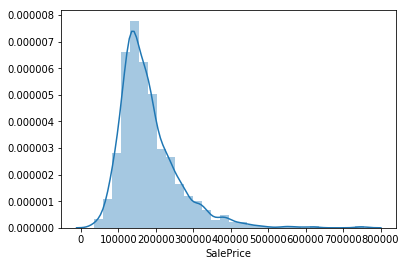

In [9]:
sns.distplot(train['SalePrice'], bins=30);

### Correlation (only numeric/numeric)

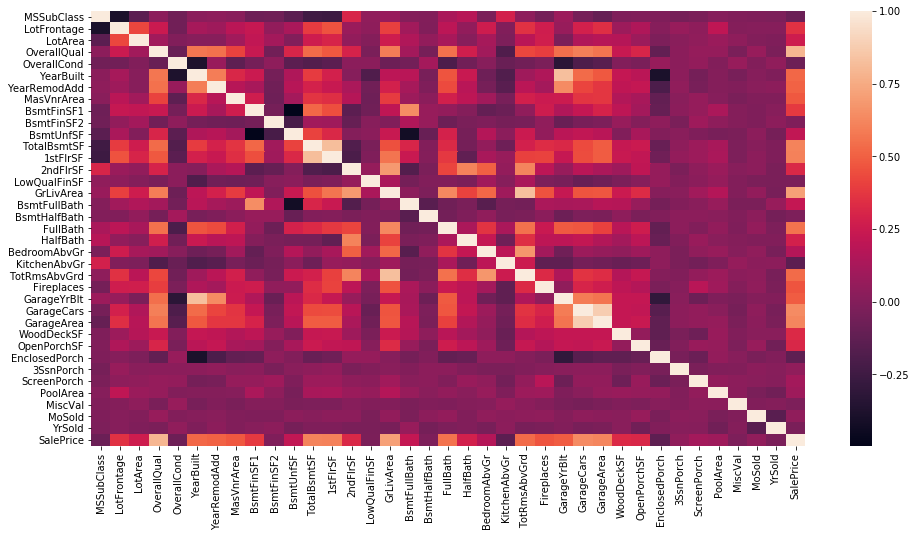

In [10]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(train.corr())

In [11]:
train.corr().loc[:, 'SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePrice, dtype: float64

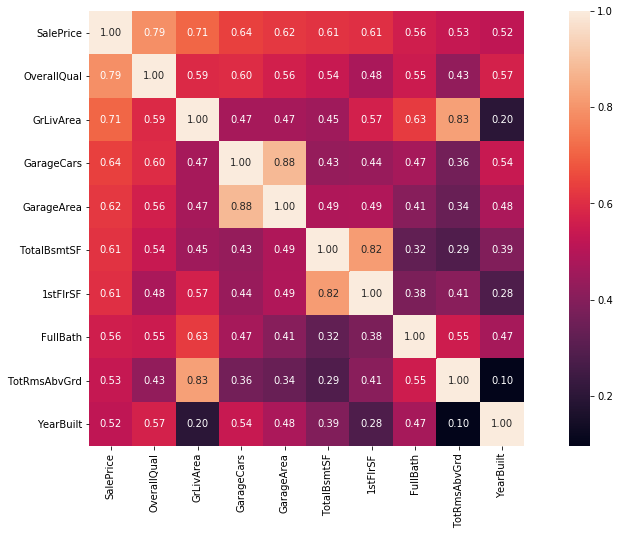

In [12]:
cols = train.corr().nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(16, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

Probably redundant: GarageCars/GarageArea, TotalBsmtSF/1stFlrSF, GrLivArea/TotRmsAbvGrd  
Extracted features: OverallQual, GrLivArea, GarageCars, TotalBsmtSF, FullBath, YearsBuilt

# Feature Engineering

**IMPORTANT** note: When you transform (change/delete/add columns) your train data you need to apply the same transformations to your test data. This is because your model will learn to make predictions with the transformed train data. It doesn't know how to handle untransformed data.

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

Only use the most important numerical features.

In [14]:
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
all_data = all_data.loc[:,cols]

### Missing data

In [15]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:40]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(30)

,Missing Ratio
TotalBsmtSF,0.034258
GarageCars,0.034258


Fill missing values with the mean of the column.

In [18]:
all_data['GarageCars'] = all_data['GarageCars'].fillna((all_data['GarageCars'].mean()))
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna((all_data['TotalBsmtSF'].mean()))

In [19]:
all_data.shape

(2919, 6)

In [20]:
all_data.ftypes

OverallQual      int64:dense
GrLivArea        int64:dense
GarageCars     float64:dense
TotalBsmtSF    float64:dense
FullBath         int64:dense
YearBuilt        int64:dense
dtype: object

In [21]:
len(test), len(train), len(train)+len(test), len(all_data)

(1459, 1460, 2919, 2919)

In [22]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [23]:
train.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
0,7,1710,2.0,856.0,2,2003
1,6,1262,2.0,1262.0,2,1976
2,7,1786,2.0,920.0,2,2001
3,7,1717,3.0,756.0,1,1915
4,8,2198,3.0,1145.0,2,2000


In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
clf = RandomForestRegressor(oob_score=True)

In [26]:
train.isnull().sum()

OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
FullBath       0
YearBuilt      0
dtype: int64

In [27]:
clf.fit(train,y_train)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:720: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [28]:
clf.oob_score_

0.72854284160086125

In [29]:
prediction = clf.predict(test)

In [30]:
prediction = pd.DataFrame(data=prediction, index=test_ID, columns=['SalePrice'])

In [31]:
prediction.head()

,SalePrice
Id,
1461,118390.8
1462,135325.0
1463,163200.9
1464,181590.0
1465,206000.0


In [32]:
prediction.to_csv('submission_baseline.csv')